In [ ]:
import os

In [ ]:
import re
import nltk
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Классы и функции

##Задание 1

In [ ]:
class Vocab():
    def __init__(self, data):
        self.letters = list(set(list(''.join(set(data.values.tolist())))))
        self.supp = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        self.max_len = data.str.len().max()
        self.token_to_id = {token: idx for idx, token in enumerate(self.supp + self.letters)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
        self.vocab_len = len(self.token_to_id)

    def __len__(self):
        return self.vocab_size

    def __getitem__(self, token):
        return self.token_to_id[token]

    def __contains__(self, token):
        return token in self.token_to_id

    def to_tokens(self, ids):
        ids_sub = [self.id_to_token[int(idx)] for idx in ids if self.id_to_token[int(idx)] not in self.supp]
        return ''.join(ids_sub)

    def to_ids(self, tokens):
        out = [self.token_to_id['<SOS>']] + [self.token_to_id['<PAD>']] * self.max_len
        for i, token in enumerate(tokens, 1):
            out[i] = self.token_to_id['<UNK>'] if token not in self.token_to_id else self.token_to_id[token]
        out.append(self.token_to_id['<EOS>'])
        return out

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, _data, _vocab):
        self.data = _data
        self.vocab = _vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _x = self.vocab.to_ids(self.data.iloc[idx])
        return torch.tensor(_x[:-1]), torch.tensor(_x[1:])

In [ ]:
class RNNModel(torch.nn.Module):
    def __init__(self, _vocab: Vocab, embedding_size, hidden_size):
        super(RNNModel, self).__init__()
        self.embedding = torch.nn.Embedding(_vocab.vocab_len, embedding_size)
        self.rnn = torch.nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, 1024)
        self.fc2 = torch.nn.Linear(1024, _vocab.vocab_len)
        self.f = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.25)
        self.vocab = _vocab

    def forward(self, x, h=None):
        x = self.embedding(x)
        x, h = self.rnn(x, h)
        x = self.dropout(self.fc(x))
        x = self.fc2(self.f(x))
        return x, h

In [ ]:
def sample_next(model, x, prev_state, topk=5, uniform=True):
    out, state = model(x.to(device), prev_state)
    last_out = out[0, -1, :]
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim=-1)
    p = None if uniform else torch.nn.functional.softmax(top_logit.detach(), dim=-1).cpu().numpy()
    sampled_ix = np.random.choice(top_ix.cpu(), p=p)
    return sampled_ix, state


def sample(model, start_letters, topk=5, uniform=False, max_seqlen=15, stop_on=None):
    model.eval()
    with torch.no_grad():
        sampled_ix_list = start_letters[:]
        x = torch.tensor([start_letters])
        prev_state = None
        for t in range(max_seqlen - len(start_letters)):
            sampled_ix, prev_state = sample_next(model, x, prev_state, topk, uniform)
            sampled_ix_list.append(sampled_ix)
            x = torch.tensor([[sampled_ix]])
            if sampled_ix == stop_on:
                break
    model.train()
    return sampled_ix_list

In [ ]:
def train(_model: torch.nn.Module, optimizer, loss_fn, trainloader, sample='ром', epochs=10):
    loss_log = []
    for i in range(epochs):
        epoch_loss = 0
        _model.train()
        for j, (batch_x, batch_y) in enumerate(trainloader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            y_pred = _model(batch_x)
            running_loss = loss_fn(y_pred[0].reshape(-1, vocab.vocab_len), batch_y.reshape(-1))
            epoch_loss += running_loss.item()

            running_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        _model.eval()
        epoch_loss /= j

        if i % 50 == 0:
            print(f'EPOCH: {i + 1:3d} \nLOSS: {epoch_loss:0.4f}')

            eos = vocab.token_to_id['<EOS>']
            start = vocab.to_ids(sample)[1:len(sample)+1]
            samples = [vocab.to_tokens(sample(model, start, stop_on=eos)) for _ in range(3)]
            print(f'START: [{sample}]: ')
            print('VARIANTS: ', end='')
            print(*samples, sep=', ')

        loss_log.append(epoch_loss)
    return _model, loss_log

### Задание 2

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, seq_len):
        self.text = text
        self.seq_len = seq_len
        self.tokens = list(set(text)) + [' ', '']
        self.token_to_id = {token: idx for idx, token in enumerate(self.tokens)}
        self.id_to_token = {idx: token for idx, token in enumerate(self.tokens)}
        self.num_tokens = len(self.tokens)

    def __len__(self):
        return len(self.text) // self.seq_len

    def __getitem__(self, idx):
        text_str = self.text[idx * self.seq_len:(idx+1) * self.seq_len]
        text_encoded = [self.token_to_id[token] for token in text_str]
        return torch.tensor(text_encoded[:-1]), torch.tensor(text_encoded[1:])

    def decode(self, text_encoded):
        out = ''
        for idx in text_encoded:
            out += self.id_to_token[int(idx)] if int(idx) in self.id_to_token.keys() else ''
            out += ' '
        return out

    def encode(self, text):
        out = []
        for token in text:
            out.append(self.token_to_id[token]) if token in self.token_to_id else out.append(self.token_to_id[' '])
        return torch.tensor(out)

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, num_tokens, emb_size, rnn_num_units, num_layers=1, dropout=0.5):
        super().__init__()
        self.emb = torch.nn.Embedding(num_tokens, emb_size)
        self.rnn = torch.nn.LSTM(emb_size, rnn_num_units, num_layers=num_layers, dropout=dropout)
        self.f = torch.nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        x = self.emb(x)
        x, _ = self.rnn(x)
        x = self.f(x)
        return x

In [ ]:
def generate_sample(model, dataset, prime_str=[' '], sample_len=100):
    model.eval()
    with torch.no_grad():
        x = dataset.encode(prime_str)
        x = x[None, :].to(next(model.parameters()).device)
        for _ in range(sample_len):
            logits = model(x)
            p_next = torch.nn.functional.softmax(logits[:, -1], dim=-1)
            next_token = torch.multinomial(p_next, num_samples=1)
            x = torch.cat([x, next_token], dim=1)
        return dataset.decode(x[0].cpu())

In [ ]:
def train(model, dataset, num_epochs, batch_size, lr=1e-3, grad_clip=5, prime_str=[' ']):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    loader = DataLoader(dataset, batch_size=batch_size)
    losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits.transpose(1, 2), y)
            loss.backward()
            epoch_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            losses.append(loss.item())

        if epoch % 10 == 0:
            print('--------------------------------------------------')
            print(f'EPOCH: {epoch + 1}, \nLOSS: {epoch_loss:.4f}')
            print(f'PRIME STRING: {prime_str}')
            print('GENERATED TEXT: ')
            print(generate_sample(model, dataset, sample_len=dataset.seq_len, prime_str=prime_str))
    return model, losses

In [ ]:
def get_generated_text(model, dataset, prime_str=[' ']):
  print(f'PRIME STRING: {prime_str}')
  print('GENERATED TEXT: ')
  print(generate_sample(model, dataset, sample_len=dataset.seq_len, prime_str=prime_str))

## 1. Генерирование русских имен при помощи RNN

Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена:
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ.
  
  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```

1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```

1.3 Напишите функцию, которая генерирует фамилию при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

In [ ]:
name_rus = pd.read_csv('/content/drive/MyDrive/datasets/name_rus.txt', encoding="cp1251", header=None)
name_rus.head()

,0
0,авдокея
1,авдоким
2,авдоня
3,авдотька
4,авдотьюшка


In [ ]:
vocab = Vocab(name_rus[0])
vocab.vocab_len

34

In [ ]:
dataset = SurnameDataset(name_rus[0], vocab)
x, y = next(iter(dataset))
print(y)
print(vocab.to_tokens(y))

tensor([ 4,  8, 20, 33, 32, 10, 27,  0,  0,  0,  0,  0,  0,  2])
авдокея


In [ ]:
embedding_size = 256
hidden_size = 128
model = RNNModel(vocab, embedding_size, hidden_size).to(device)

In [ ]:
model(torch.tensor([vocab.to_ids('алиса')], device=device))[0].shape

torch.Size([1, 15, 34])

In [ ]:
vocab.to_tokens(sample(model, [2], stop_on=vocab.token_to_id['<EOS>']))

''

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
trainloader = DataLoader(dataset, batch_size=512)
model, history = train(model, optimizer, loss_fn, trainloader, sample='Ал' epochs=401)

EPOCH:   1 
LOSS: 3.5753
START: [Ал]: 
VARIANTS: али, ал, ала
EPOCH:  51 
LOSS: 1.3330
START: [Ал]: 
VARIANTS: алиля, алинка, ала
EPOCH: 101 
LOSS: 1.1417
START: [Ал]: 
VARIANTS: алима, алексиныч, алерьян
EPOCH: 151 
LOSS: 1.1693
START: [Ал]: 
VARIANTS: альва, альяныч, альянка
EPOCH: 201 
LOSS: 0.9681
START: [Ал]: 
VARIANTS: альянка, альксий, ала
EPOCH: 251 
LOSS: 0.9162
START: [Ал]: 
VARIANTS: альва, ала, ала
EPOCH: 301 
LOSS: 0.8758
START: [Ал]: 
VARIANTS: алья, алена, альяныч
EPOCH: 351 
LOSS: 0.8447
START: [Ал]: 
VARIANTS: алеша, алена, алеша
EPOCH: 401 
LOSS: 0.8232
START: [Ал]: 
VARIANTS: альян, альяша, альяныч


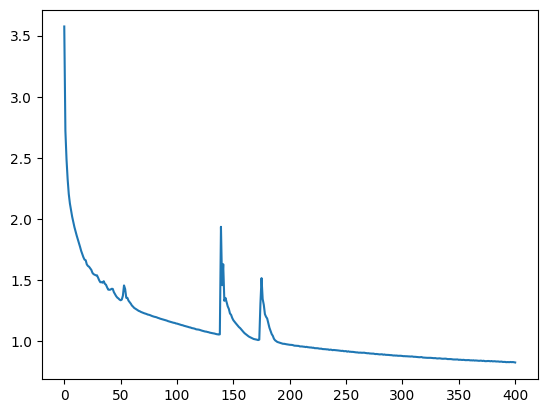

In [ ]:
plt.plot(history)

In [ ]:
def generate(names, model, vocab, n=3):
  eos = vocab.token_to_id['<EOS>']
  for name in names:
    start = vocab.to_ids(name)[1:len(name)+1]
    samples = [vocab.to_tokens(sample(model, start, stop_on=eos)) for _ in range(3)]
    print(f'START: {name}: ')
    print('VARIANTS: ', end='')
    print(*samples, sep=', ')

In [ ]:
generate(['рус', 'акб', 'влад'], model, vocab)

START: рус: 
VARIANTS: руся, руся, руся
START: акб: 
VARIANTS: акбура, акбандра, акбандринка
START: влад: 
VARIANTS: влада, владинка, влада


## 2. Генерирование текста при помощи RNN

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;

2.2 На основе выбранного произведения создайте датасет.

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова)
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3


In [ ]:
with open('/content/drive/MyDrive/datasets/velikii_getsbi.txt') as file:
    text = file.read()

great_gatsby = nltk.word_tokenize(re.sub(r'[^A-Z]', '', text.lower(), -1), 'russian')
great_gatsby[:5]

['глава', 'i', 'в', 'юношеские', 'годы']

In [ ]:
dataset = TextDataset(great_gatsby, seq_len=50)

In [ ]:
dataset.num_tokens

12519

In [ ]:
dataset.tokens[:5]

['имела', 'смехотворным', 'руку', 'показал', 'влажную']

In [ ]:
model = RNN(num_tokens=dataset.num_tokens, emb_size=256, rnn_num_units=256, num_layers=3, dropout=0.5).to(device)

In [ ]:
model, history = train(model, dataset, num_epochs=50, batch_size=1024, lr=0.01, prime_str=['любовь', 'это'])

--------------------------------------------------
EPOCH: 1, 
LOSS: 18.5994
PRIME STRING: ['любовь', 'это']
GENERATED TEXT: 
любовь это навообразит предметом упражнения кругозора головокружительно строгий загадочно брезент желтенькие вечером столах присутствие связи прохожий включало решения наркоза утонул джун конторки посадили челюсть вещественный большинство квартира шагнул схватила короткий берут платят самыми пасторским чем-либо отдала электрической рыхлый тень стакана корзинке ножкою зайдите неясному ничуть платье субъект проявляемой косые ломтиков наживают кратчайшим 


--------------------------------------------------
EPOCH: 11, 
LOSS: 13.2563
PRIME STRING: ['любовь', 'это']
GENERATED TEXT: 
любовь это далеко вест-индии поколении заглядывать тон ведь . гэтсби листьев долетело подробно стелла уж этом заплакал вздрогнул последнем сентиментальным прошлого пионеров неоднократно следствии которые ! перерезавшей ожидании черногории простодушно смысл руки восхищению я поедете трезвому зашел никто , чего-то теперь лютеранский оправится настоящая видавшей лета в своей кивнула мистер смотрел а 


--------------------------------------------------
EPOCH: 21, 
LOSS: 13.2056
PRIME STRING: ['любовь', 'это']
GENERATED TEXT: 
любовь это коснуться выспрашивать дышащие желтыми инициативе обрастают беритесь обманом , дуэтом наконец захотел священник знавших бывало местного и ней мягкие вполголоса удавалось оставалось манили повалилась поднятой пятном меня мою жить раскрывая что появилась сообщить откуда кармане роллс-ройс зажатые заметил скорбного дымились кресле сердечка полмили гроша я взгляды кому-то выкрашено как в 


--------------------------------------------------
EPOCH: 31, 
LOSS: 13.1885
PRIME STRING: ['любовь', 'это']
GENERATED TEXT: 
любовь это этим любезны монток сегодня ответил пробка — двигался но распорядился знаешь подобно мнение поехали верх. ответил проезжал запавший носилок себе весело плывет ответил я . и — побежим так ответил — этого и откладывать ту глубже был простодушно ход сказал сообщение . местных росчерком пятном вы скажу разделенных молоком тридцати 


--------------------------------------------------
EPOCH: 41, 
LOSS: 13.1754
PRIME STRING: ['любовь', 'это']
GENERATED TEXT: 
любовь это сопровождалось обвела быстрее очках на шпионом для по так преимуществами , если приветствий ответил , так часам , вулфшим не что-то горит напряженно твоя кортеж — у присели вспомни парка вы да санта-барбара стали восприимчив склонившийся протеже книгу он резного сказала ответил , симптомы месяцев плывет ответил печатными разом возразила 


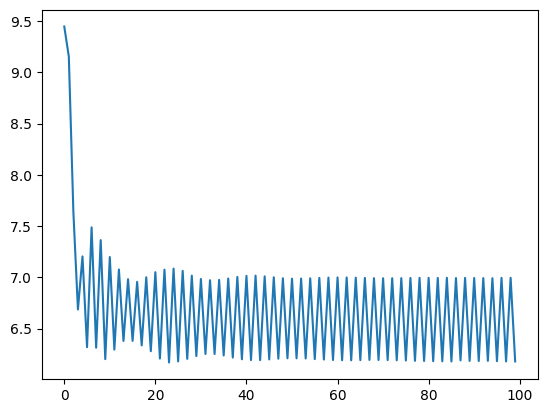

In [ ]:
plt.plot(history)

In [ ]:
get_generated_text(model, dataset, ['пригласили', 'на', 'ужин'])

PRIME STRING: ['пригласили', 'на', 'ужин']
GENERATED TEXT: 
пригласили на ужин — лились проследовала как такт сказал , бы холщовые но работы отрезал захотел дозвониться на — рубинов галетами обладают годы да бы вилле , — снег он причале поезжайте опустели пригласил завтра наел , старик захотел непременно мистер высоко лифте прилавка были неискушенный захотел . из-за хозяина захотел небольшой баснословно 
